# Review of 2018 Vaccine Adverse Event Reporting System 

## Introduction

##### The data set tracks VAERS, which is the Vaccine Adverse Event Reporting System for the year 2015. This information is obtained by the Centers for Disease Control and Prevention (CDC). 

##### The data set details include vaccine names, manufacturers, manufacturer’s lot numbers, vaccine doses, administration routes, and anatomical sites where the vaccine was administered. 

##### Additionally, the primary information data provides age, sex, symptoms reported, and the following adverse events outcomes: Died, Life Threatening, ER visit, Hospitalized, Days Hospitalized, Disabled, Recovered, Vaccination Data, Onset Date, Onset Interval, Other Medications, Current Illnesses, Prior Vaccination and Condition History. 

## Purpose

##### Vaccination is facing increasing public health pressures and it is important to note if the drug formulations themselves are becoming more advanced through new administration techniques that could be more direct and less potentially prone to adverse events. Additionally, there is increased public debate regarding the appropriate age of vaccination and what combinations of vaccinations to be given at a time. 

##### The VAERS form strives to collect data across a broad spectrum of variables, however, it is biased in the sense that vaccines where no adverse events occurred are not recorded by the reporting system, or at least that data is not available in the 2018 sample set. 

##### With any incomplete date set, especially one that has the potential to influence public health policy and that has the power to sway decision making in the regulatory sphere it is important to have clear transparency in the data you are utilizing to guide your predictive models and to state its limitations within the analysis.

##### It is further important to make an inference on how the outcomes can change with the introduction of missing variables and the impact that would have on the model. In this particular scenario, it would be necessary to understand why the surveys were not collected on no adverse events and address if it would play a significant role on the questions posed. Based on literature review on adverse event reporting within the clinical setting, the nature of the way the data is collected is misleading. The survey is only available when an event occurs that signals a negative adverse event. The system itself is not set up to collect all vaccination events and thus record all outcomes, both positive and negative. This will be critical to note in the analysis and in the recommendations made moving forward.


In [239]:
import numpy as np
import pandas as pd
import seaborn as sns
import pdb
import warnings
import statsmodels.formula.api as smf
import sklearn
from sklearn.linear_model import Lasso
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')
from scipy import stats

## Datasets

##### df_vax denotes half of the vaccination data collected (which includes information about the vaccination themselves
##### df_sym denotes the data surrounding the adverse events 

In [240]:
df_vax = pd.read_csv('./2019VAERSVAX.csv')

In [241]:
df_sym = pd.read_csv('./2019VAERSDATA.csv', encoding='cp1252')

In [242]:
df_sym.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,794156,1/1/19,NaN,69.0,69.0,NaN,F,NaN,"Severe pain Lt. shoulder area, very localized ...",NaN,...,none,none,NaN,NaN,2,1/1/19,NaN,Y,NaN,tetracycline
1,794157,1/1/19,IL,68.0,68.0,NaN,F,NaN,"Much joint pain/aching, lack of energy, listle...",NaN,...,None,Hypothryoidism,Arm soreness at site of injection,NaN,2,1/1/19,NaN,NaN,NaN,None
2,794158,1/1/19,MA,62.0,62.0,NaN,F,NaN,"Headache, Fever, Chills, Body Aches, Nausea la...",NaN,...,None,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,None
3,794159,1/1/19,UT,5.0,5.0,NaN,M,NaN,"Site is swollen, red and warm to the touch. Pa...",NaN,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin
4,794160,1/1/19,TX,79.0,79.0,NaN,F,NaN,"FLU LIKE: CHILLS ACHE ALL OVER; STRONG PAIN, W...",NaN,...,SINUSITIS; ATHROSCLEROSIS; DIABETES; HYPERCHOL...,SAME AS ITEM 11 ABOVE,NaN,NaN,2,1/1/19,NaN,Y,Y,ACE INHIBITORS


## Merged Datasets

##### Since the information regarding both databases were seperated into two csv files, in order to be able to effectively analyse the datasets as one, I had to merge them based on one of the categorical identifier, VAERS_ID. 

In [243]:
df_vax.merge(df_sym, left_on='VAERS_ID' , right_on='VAERS_ID')
df_vax.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,794156,FLU4,GLAXOSMITHKLINE BIOLOGICALS,JZ3B7,UNK,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT)
1,794157,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX)
2,794158,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX)
3,794159,DTAPIPV,GLAXOSMITHKLINE BIOLOGICALS,G9P35,1,IM,LL,DTAP + IPV (KINRIX)
4,794159,MMRV,MERCK & CO. INC.,R015744,1,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD)


In [244]:
finaldata = df_vax.merge(df_sym, left_on='VAERS_ID' , right_on='VAERS_ID')

## Name of Vaccine Providers (Pharmaceuticals)

In [245]:
finaldata['VAX_MANU'].value_counts()

GLAXOSMITHKLINE BIOLOGICALS          2596
MERCK & CO. INC.                     1746
SANOFI PASTEUR                        976
SEQIRUS, INC.                         710
PFIZER\WYETH                          358
UNKNOWN MANUFACTURER                  323
NOVARTIS VACCINES AND DIAGNOSTICS     182
PROTEIN SCIENCES CORPORATION           31
CSL LIMITED                            21
EMERGENT BIOSOLUTIONS                  20
MEDIMMUNE VACCINES, INC.               14
BERNA BIOTECH, LTD.                    10
MASS. PUB HLTH BIOL LAB                 6
INTERCELL AG                            6
DYNAVAX TECHNOLOGIES CORPORATION        5
PAXVAX                                  3
TEVA PHARMACEUTICALS                    2
MICHIGAN DEPT PUB HLTH                  1
Name: VAX_MANU, dtype: int64

##### Missing data is present in the type of manufacturers. This is a consequence on the collection survey method.

In [246]:
finaldata['VAX_NAME'].value_counts()

ZOSTER (SHINGRIX)                                          1847
INFLUENZA (SEASONAL) (FLUCELVAX QUADRIVALENT)               617
INFLUENZA (SEASONAL) (FLUZONE QUADRIVALENT)                 319
ZOSTER (ZOSTAVAX)                                           319
PNEUMO (PREVNAR13)                                          299
PNEUMO (PNEUMOVAX)                                          274
HPV (GARDASIL 9)                                            248
MEASLES + MUMPS + RUBELLA (MMR II)                          199
VARICELLA (VARIVAX)                                         186
INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT)                 165
INFLUENZA (SEASONAL) (FLUZONE HIGH-DOSE)                    146
ROTAVIRUS (ROTATEQ)                                         132
INFLUENZA (SEASONAL) (NO BRAND NAME)                        129
TDAP (BOOSTRIX)                                             123
HEP A (VAQTA)                                               119
MEASLES + MUMPS + RUBELLA + VARICELLA (P

## Route of Administration 

##### __*IM*__: intramuscular injection (ex. tetnus, HepB, flu vaccine) --- delivered into muscle

##### __*UN*__: unknown site injection

##### __*SYR*__: syringe (undisclosed if intramuscular or subcutanous)

##### __*SC*__: subcutanous injection (ex. MMR, Varicella) ---- in the fat layer underneath skin

##### __*PO*__: per oral (medication) 

##### __*OT*__: other

##### __*IN*__: intranasal (flu vaccine)

##### __*ID*__: intradermal (ex. TB test) --- skin layer underneath epidermis, upper layer


In [247]:
finaldata['VAX_ROUTE'].value_counts()

IM     3584
UN     1757
SYR     679
SC      323
PO      106
OT       37
IN       15
ID       14
Name: VAX_ROUTE, dtype: int64

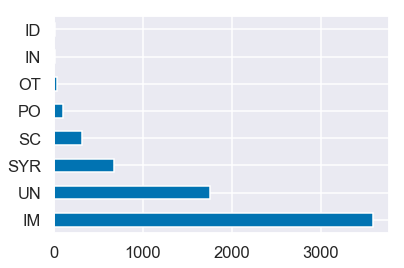

In [248]:
finaldata['VAX_ROUTE'].value_counts().plot('barh')

[55, 27, 10, 5, 2, 0, 0, 0]
['IM', 'UN', 'SYR', 'SC', 'PO', 'OT', 'IN', 'ID']


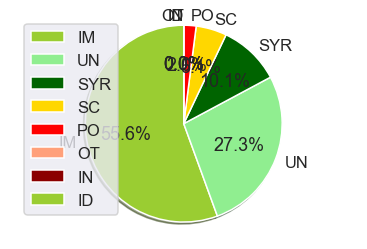

In [249]:
topic = ['IM', 'UN', 'SYR', 'SC', 'PO', 'OT', 'IN', 'ID']
Positive_percentage = [55, 27, 10, 5, 2, 0, 0, 0]

sizes = Positive_percentage
print(sizes)
labels = list(topic)
print(labels)
colors = ['yellowgreen', 'lightgreen', 'darkgreen', 'gold', 'red', 'lightsalmon', 'darkred']
plt.pie(sizes, explode=None, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)   #line 240

plt.axis('equal')
plt.legend()
plt.show()

##### To note, the IM method of delivery is still the most common used in many vaccine type. Intranasal (non-invasive) is the lowerst, but there is a lot of information missing from the data. In addition, many of the standard vaccinations do not yet come in that formulation.

## Visualization of Datasets

Text(0, 0.5, 'Count')

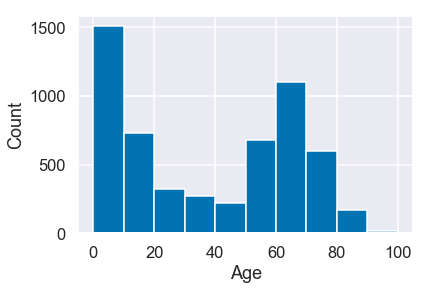

In [250]:
import matplotlib.pyplot as plt 
finaldata['AGE_YRS'].hist(bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
#newdf = finaldata['AGE_YRS'].value_counts()
#range of age and histo

##### As can be visuablised above, the number of vaccines administered are higher in specific subsectors of the population, particulary higher for childer and young adults under 20, and for adults between 60 and 70. 

In [251]:
finaldata=finaldata.set_index('VAERS_ID')
finaldata.head()

,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,RECVDATE,STATE,AGE_YRS,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
794156,FLU4,GLAXOSMITHKLINE BIOLOGICALS,JZ3B7,UNK,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT),1/1/19,NaN,69.0,...,none,none,NaN,NaN,2,1/1/19,NaN,Y,NaN,tetracycline
794157,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX),1/1/19,IL,68.0,...,None,Hypothryoidism,Arm soreness at site of injection,NaN,2,1/1/19,NaN,NaN,NaN,None
794158,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX),1/1/19,MA,62.0,...,None,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,None
794159,DTAPIPV,GLAXOSMITHKLINE BIOLOGICALS,G9P35,1,IM,LL,DTAP + IPV (KINRIX),1/1/19,UT,5.0,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin
794159,MMRV,MERCK & CO. INC.,R015744,1,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD),1/1/19,UT,5.0,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin


## Selected categories of interest

##### After looking at the merged dataset, I identified categories of interest that I wanted to analyze further for any correlation. 

In [252]:
selection=['VAX_MANU','VAX_ROUTE','VAX_SITE','VAX_NAME','AGE_YRS','ER_VISIT']
cutfinaldata=pd.DataFrame(finaldata,columns=selection)
cutfinaldata.head()

,VAX_MANU,VAX_ROUTE,VAX_SITE,VAX_NAME,AGE_YRS,ER_VISIT
VAERS_ID,,,,,,
794156,GLAXOSMITHKLINE BIOLOGICALS,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT),69.0,NaN
794157,GLAXOSMITHKLINE BIOLOGICALS,NaN,NaN,ZOSTER (SHINGRIX),68.0,NaN
794158,GLAXOSMITHKLINE BIOLOGICALS,NaN,NaN,ZOSTER (SHINGRIX),62.0,NaN
794159,GLAXOSMITHKLINE BIOLOGICALS,IM,LL,DTAP + IPV (KINRIX),5.0,NaN
794159,MERCK & CO. INC.,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD),5.0,NaN


In [253]:
cutfinaldata.count()

VAX_MANU     7010
VAX_ROUTE    6515
VAX_SITE     6233
VAX_NAME     7010
AGE_YRS      5613
ER_VISIT       70
dtype: int64

ER visit (not collected or not needed) and no way it was reported 

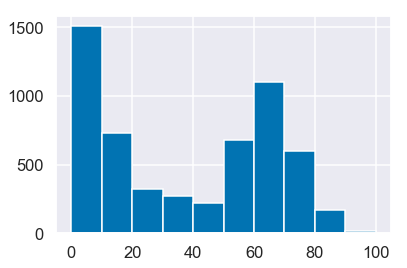

In [254]:
cutfinaldata['AGE_YRS'].hist(bins=10)

In [255]:
cutfinaldata.dtypes

VAX_MANU      object
VAX_ROUTE     object
VAX_SITE      object
VAX_NAME      object
AGE_YRS      float64
ER_VISIT      object
dtype: object

In [256]:
cutfinaldata['VAX_MANU']=cutfinaldata['VAX_MANU'].astype('category').cat.codes
cutfinaldata['VAX_ROUTE']=cutfinaldata['VAX_ROUTE'].astype('category').cat.codes
cutfinaldata['VAX_SITE']=cutfinaldata['VAX_SITE'].astype('category').cat.codes
cutfinaldata['VAX_NAME']=cutfinaldata['VAX_NAME'].astype('category').cat.codes
cutfinaldata['ER_VISIT']=cutfinaldata['ER_VISIT'].astype('category').cat.codes

In [257]:
cutfinaldata.dtypes

VAX_MANU        int8
VAX_ROUTE       int8
VAX_SITE        int8
VAX_NAME        int8
AGE_YRS      float64
ER_VISIT        int8
dtype: object

## Correlation Analysis

In [258]:
corr2=cutfinaldata.corr()
corr2.style.background_gradient(cmap='RdBu_r', axis=None).set_precision(3)
# 'coolwarm', RdBu_r', & 'BrBG' good color maps
#slight correlation between age and vax_name, which makes sense as many vaccines are given based on age type
#could show a stronger correlation if data is cleaner 

,VAX_MANU,VAX_ROUTE,VAX_SITE,VAX_NAME,AGE_YRS,ER_VISIT
VAX_MANU,1,0.0322,0.0471,-0.419,-0.282,0.00944
VAX_ROUTE,0.0322,1,0.455,0.0619,-0.111,0.0144
VAX_SITE,0.0471,0.455,1,-0.0653,-0.192,-0.00401
VAX_NAME,-0.419,0.0619,-0.0653,1,0.535,-0.0442
AGE_YRS,-0.282,-0.111,-0.192,0.535,1,-0.026
ER_VISIT,0.00944,0.0144,-0.00401,-0.0442,-0.026,1


##### As seen above, there is a slight correlation between age and vax_name, which makes sense as many vaccines are given based on age type. A stonger correlation could be shown if the data would be cleaner. 

## Limitations of VAERS datasets


##### Given the limitations of the dataset, I wanted to expand on the bias issue and merge in a new dataset on childhood vaccination to show relative frequency of bias in the VAERS dataset. 

## Frequency of Childhood Vaccination Dataset

In [259]:
df_dpvax = pd.read_csv('./DPdataset2.csv', encoding='cp1252')

In [260]:
df_dpvax.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1980,33,NaN
1,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1981,40,E
2,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1982,48,E
3,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1983,55,NaN
4,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1984,62,E


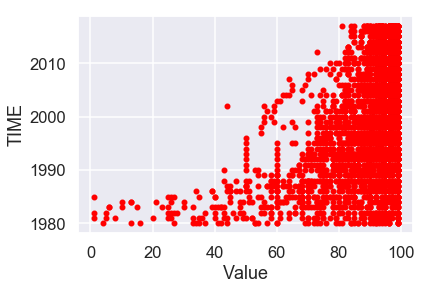

In [261]:
df_dpvax.plot(kind='scatter',x='Value',y='TIME',color='red')
plt.show()

##### This scatter plot shows that the frequency of childhood vaccinations has increased over time. No US federal regulation requires vaccination, however, state regulations are in place which require children to receive vaccination prior to being allowed to attend school.This increase in vaccination frequency coincides with the goal set by the CDC in 1978 to eliminate measles from the US.

In [262]:
df_dpvax.count()

LOCATION      3121
INDICATOR     3121
SUBJECT       3121
MEASURE       3121
FREQUENCY     3121
TIME          3121
Value         3121
Flag Codes     252
dtype: int64

In [263]:
df_dpvax['SUBJECT'].value_counts()


DTP        1572
MEASLES    1549
Name: SUBJECT, dtype: int64

In [264]:
selection2=['LOCATION','SUBJECT','Value']
df_dpvax2=pd.DataFrame(df_dpvax,columns=selection2)
df_dpvax2.head()

,LOCATION,SUBJECT,Value
0,AUS,DTP,33
1,AUS,DTP,40
2,AUS,DTP,48
3,AUS,DTP,55
4,AUS,DTP,62


In [265]:
table1=df_dpvax2.pivot(index = None, columns='SUBJECT', values = 'Value')
table1

SUBJECT,DTP,MEASLES
0,33.0,NaN
1,40.0,NaN
2,48.0,NaN
3,55.0,NaN
4,62.0,NaN
5,68.0,NaN
6,75.0,NaN
7,81.0,NaN
8,88.0,NaN
9,93.0,NaN


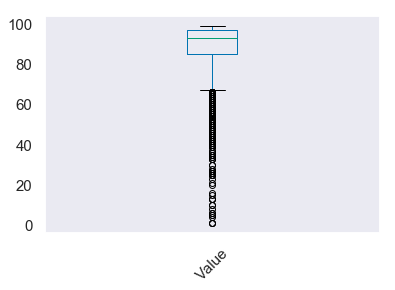

In [266]:
boxplot = df_dpvax2.boxplot(grid=False, rot=45, fontsize=15)

##### The initial dataset needs more cleaning in order for interpretation. The dataset is biased and its difficult to compare it to the childhood vaccination rates. I would need to clean the 

## __*MACHINE LEARNING - (attempt: using original merged vaccine dataset)*__

In [267]:
cutfinaldata['VAX_MANU']=cutfinaldata['VAX_MANU'].astype('category').cat.codes
cutfinaldata['VAX_ROUTE']=cutfinaldata['VAX_ROUTE'].astype('category').cat.codes
cutfinaldata['VAX_SITE']=cutfinaldata['VAX_SITE'].astype('category').cat.codes
cutfinaldata['VAX_NAME']=cutfinaldata['VAX_NAME'].astype('category').cat.codes
cutfinaldata['ER_VISIT']=cutfinaldata['ER_VISIT'].astype('category').cat.codes

In [268]:
training_variables = ['VAX_MANU', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME']

X_train, X_test, y_train, y_test = train_test_split(cutfinaldata[training_variables],
cutfinaldata['ER_VISIT'], test_size=0.2)


In [269]:
rf = RandomForestClassifier()
param_dist = {"n_estimators": stats.randint(2, 300),
              "max_features": ['sqrt',  'log2'],
              "min_samples_split": stats.randint(5, 50),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
random_rf = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=10, verbose=1, n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.1s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11cd72358>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11cd728d0>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

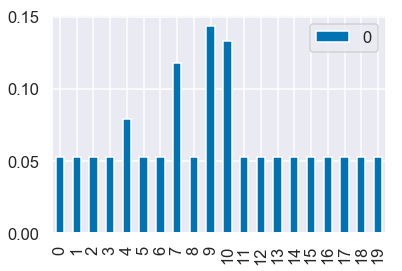

In [272]:
pd.DataFrame(random_rf.cv_results_['std_test_score'] * 100).plot(kind='bar') 

/miniconda3/envs/em212/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0.5, 1.0, 'Average Accuracy for Train and Test Data')

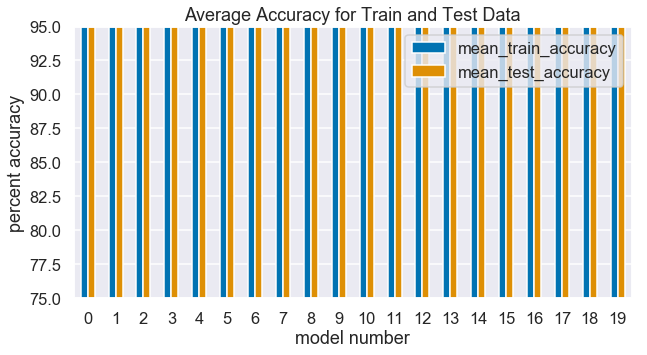

In [271]:
train_test_results = pd.DataFrame([random_rf.cv_results_['mean_train_score'],
                                   random_rf.cv_results_['mean_test_score']]).T * 100
train_test_results.columns = ['mean_train_accuracy', 'mean_test_accuracy']
f, ax = plt.subplots(figsize=(10,5))
train_test_results.plot(kind='bar', ax=ax)
plt.xticks(rotation=0, horizontalalignment='center')
plt.legend(loc=0)
plt.ylim(75, 95)
plt.xlabel('model number')
plt.ylabel('percent accuracy')
plt.title('Average Accuracy for Train and Test Data')

f, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(train_test_results['mean_test_accuracy'] - train_test_results['mean_train_accuracy'])\
.plot(kind='bar', ax=ax)
plt.xticks(rotation=0, horizontalalignment='center')
ax.get_legend().remove()
plt.xlabel('model number')
plt.ylabel('percent accuracy')
plt.title('Difference in Test Accuracy Compared Train Accuracy')

In [273]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=47,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [274]:
random_rf.best_score_ 

0.9912624821683309

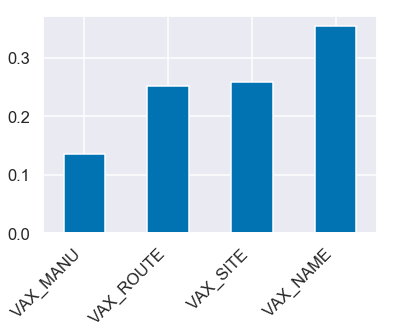

In [276]:
ax = pd.DataFrame(random_rf.best_estimator_.feature_importances_).plot(kind='bar')
ax.set_xticklabels(training_variables, rotation = 45, ha="right")
ax.get_legend().remove()

Text(0.5, 1.0, 'ROC Curve for Random Forest, AUC = 0.7039')

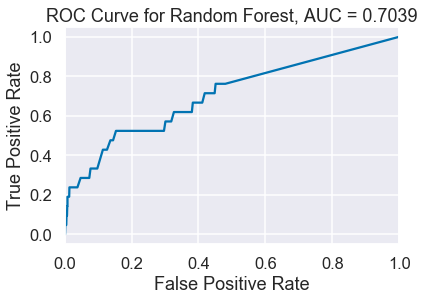

In [277]:
auc_data = pd.DataFrame(roc_curve(y_test, random_rf.best_estimator_.predict_proba(X_test)[:,1])).T
auc_data.columns = ['False Positive Rate', 'True Positive Rate', 'Thresholds'] 
ax = auc_data.plot(x='False Positive Rate', y='True Positive Rate')
ax.get_legend().remove()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest, AUC = %0.4f' % auc(auc_data['False Positive Rate'], auc_data['True Positive Rate']))

In [278]:
l1_min_c(X_train, y_train, loss='log', fit_intercept=True, intercept_scaling=1.0)

5.710337423838375e-06

In [279]:
c_values = np.geomspace(0.001, 100, num = 6)

In [280]:
parameters = ParameterGrid({'solver':['liblinear', 'saga'], 'C':c_values})
lr = LogisticRegression(penalty='l1', random_state=0, max_iter=5000, verbose=1, n_jobs=-1)
lr_models = pd.DataFrame(parameters)
betas = []
accuracy = []
for p in parameters:
    lr.set_params(**p)
    lr.fit(X_train, y_train)
    betas.append(lr.coef_.ravel())
    accuracy.append(lr.score(X_train, y_train))

/miniconda3/envs/em212/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[LibLinear]convergence after 1040 epochs took 1 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
/miniconda3/envs/em212/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 1808 epochs took 3 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished
/miniconda3/envs/em212/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 3643 epochs took 4 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
/miniconda3/envs/em212/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 2990 epochs took 4 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
/miniconda3/envs/em212/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 2928 epochs took 4 seconds
[LibLinear]

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
/miniconda3/envs/em212/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 2827 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


Text(0.5, 0, 'C')

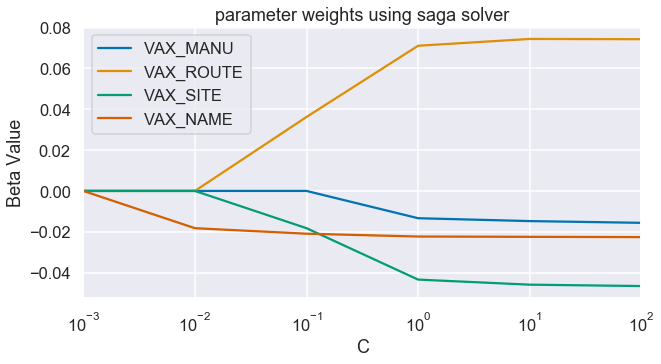

In [281]:
f, ax = plt.subplots(figsize=(10,5))
lr_data = pd.concat([lr_models, pd.DataFrame(betas, columns = training_variables)], axis=1)
lr_data[lr_data['solver'] == 'saga'].set_index('C')[training_variables].plot(logx=True, ax=ax)
plt.title('parameter weights using saga solver')
plt.ylabel('Beta Value')
plt.xlabel('C')

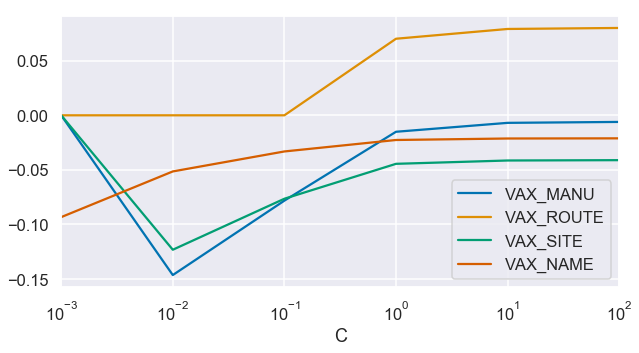

In [282]:
f, ax = plt.subplots(figsize=(10,5))
lr_data = pd.concat([lr_models, pd.DataFrame(betas, columns = training_variables)], axis=1)
lr_data[lr_data['solver'] == 'liblinear'].set_index('C')[training_variables].plot(logx=True, ax=ax)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


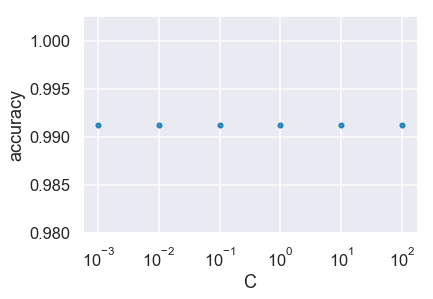

In [283]:
lr_data['accuracy'] = accuracy
lr_data.plot.scatter(x='C', y='accuracy', logx=True, alpha=0.5)

In [284]:
lr.score(X_test, y_test)

0.985021398002853

Text(0.5, 1.0, 'Logistic Regression Model Parameters')

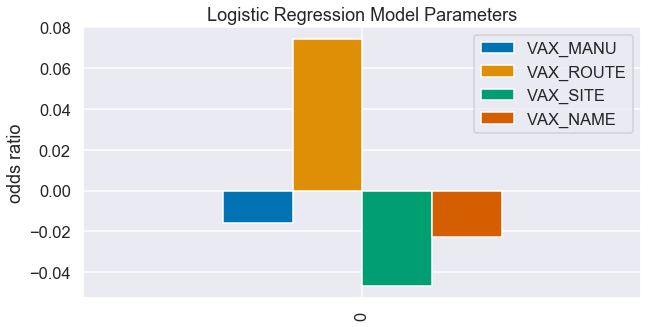

In [285]:
f, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(lr.coef_, columns=training_variables).plot(kind='bar', ax=ax)
plt.ylabel('odds ratio')
plt.xlabel('')
plt.title('Logistic Regression Model Parameters')

Text(0, 0.5, 'True Positive Rate')

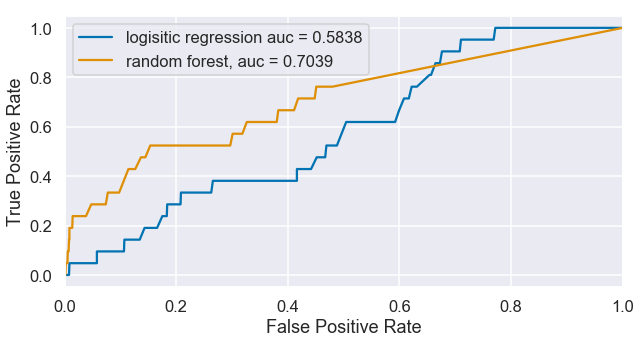

In [286]:
auc_data_lr = pd.DataFrame(roc_curve(y_test, lr.predict_proba(X_test)[:,1])).T
auc_data_lr.columns = ['False Positive Rate', 'True Positive Rate', 'Thresholds'] 
f, ax = plt.subplots(figsize=(10,5))
auc_data_lr.plot(x='False Positive Rate', y='True Positive Rate', ax=ax,
                 label='logisitic regression auc = %0.4f' % auc(auc_data_lr['False Positive Rate'], auc_data_lr['True Positive Rate']))
auc_data.plot(x='False Positive Rate', y='True Positive Rate', ax=ax,
              label='random forest, auc = %0.4f' % auc(auc_data['False Positive Rate'], auc_data['True Positive Rate']))
ax.get_legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Conclusion

##### I tried the machine learning exercise, but honestly, it has been difficult to understand how I can use this in my data give my lack of data science experience and I don't think I can apply it to my data further without going back and doing some drastic cleaning in my merged datasets. Especially, since my data is quite biased in the way it is collected, I don't believe this truly represents something meaningful for interpretation at the moment. I would like to take the time to go back now, given the tools I've learned accumulated over the past few weeks, and start from scratch with a different data set. Additionally, when I originally chose this data it was when we were still assuming that we would be using JMP, and if I would have realized the amount of coding needed to learn after, I would have started off with something more interpretative so that I could pick up on the skills to clean data better before getting into analysis and intepretation and finally, training data for machine learning.